In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from datetime import date
from typing import Tuple, List

In [3]:
df = sns.load_dataset('diamonds')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df = df.select_dtypes(include=['float64', 'int64'])
df.isnull().sum()

carat    0
depth    0
table    0
price    0
x        0
y        0
z        0
dtype: int64

In [5]:
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [6]:
df.shape

(53940, 7)

### Implementation of *Local Outlier Factor* algorithm

#### Metrics definition

In [7]:
def euclidean_distance(x, y, axis=0):
    return np.sqrt(np.sum((x - y) ** 2, axis=axis))

def manhattan_distance(x, y, axis=0):
    return np.sum(np.abs(x - y), axis=axis)

#### K-Distance & K-Neighbors

In [8]:
def k_neighbors(point: np.ndarray, neighbors: np.ndarray, k: int, distance=euclidean_distance):
    pds = []
    for neighbor in neighbors:
        pds.append((neighbor, distance(point, neighbor)))
    pds = sorted(pds, key=lambda x: x[1])
    if len(pds) >= k:
        k_distance = pds[k-1][1]
        k_neighbors = np.array([pd[0] for pd in pds if pd[1] <= k_distance])
        return k_distance, k_neighbors
    else:
        return None, None

#### Reachability Density

In [9]:
def reachability_density(xi: np.ndarray, xj: np.ndarray, neighbors: np.ndarray, k: int, distance=euclidean_distance):
    xj_k_distance, _ = k_neighbors(xj, neighbors, k, distance)
    if xj_k_distance is not None:
        return max(xj_k_distance, distance(xi, xj))
    else:
        return 0

#### Local Reachability Density

In [10]:
def local_reachability_density(point: np.ndarray, neighbors: np.ndarray, k: int, distance=euclidean_distance):
    lrd = 0.0
    _, point_k_neighbors = k_neighbors(point, neighbors, k, distance)
    for xj in point_k_neighbors:
        lrd += reachability_density(point, xj, neighbors, k, distance)
    return 1.0 / (lrd / (len(point_k_neighbors) + 0.0000001))

#### Local Outlier Factor

In [11]:
def local_outlier_factor(point: np.ndarray, neighbors: np.ndarray, k: int, distance=euclidean_distance):
    _, point_k_neighbors = k_neighbors(point, neighbors, k, distance)
    lrd_sum = 0.0
    for xj in point_k_neighbors:
        lrd_sum += local_reachability_density(xj, neighbors, k, distance)
    return (lrd_sum / len(point_k_neighbors)) * (1.0 / local_reachability_density(point, neighbors, k, distance))

#### Verification

(4, 2)


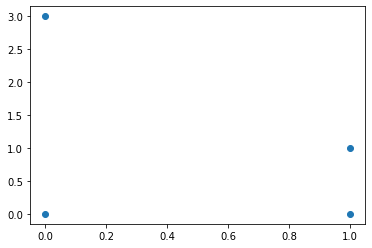

In [12]:
points = [[0, 0], [1, 0], [1, 1], [0, 3]]
points = np.array(points)
print(points.shape)
plt.scatter(points[:, 0], points[:, 1])
plt.show()

In [ ]:
k = 2
for idx, point in enumerate(points):
    new_points = np.array([p for i, p in enumerate(points) if i != idx])
    kd, kn = k_neighbors(point, new_points, k, distance=manhattan_distance)
    print(f'{k}-distance({point}) = {kd}')
    print(f'||{k}-neighbors({point})|| = {len(kn)}')
    print(f'LRD_{k}({point}) = {local_reachability_density(point, new_points, k, distance=manhattan_distance):.4f}')
    print(f'LOF_{k}({point}) = {local_outlier_factor(point, new_points, k, distance=manhattan_distance):.4f}\n')